In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score


df2 = pd.read_csv('data/onlybookings.csv')
df2.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-02-27 18:01:32,2,3,66,318,52078,NaN,756,0,1,...,0,1,8291,1,1,1,2,50,191,2
3,2013-06-15 15:38:05,30,4,195,548,56440,NaN,1048,0,1,...,0,1,1385,1,1,1,0,185,185,58
4,2014-11-23 18:02:20,30,4,195,991,47725,NaN,1048,0,0,...,0,1,8803,1,1,1,3,151,69,36


In [2]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000001 entries, 0 to 1000000
Data columns (total 24 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   date_time                  1000001 non-null  object 
 1   site_name                  1000001 non-null  int64  
 2   posa_continent             1000001 non-null  int64  
 3   user_location_country      1000001 non-null  int64  
 4   user_location_region       1000001 non-null  int64  
 5   user_location_city         1000001 non-null  int64  
 6   orig_destination_distance  661222 non-null   float64
 7   user_id                    1000001 non-null  int64  
 8   is_mobile                  1000001 non-null  int64  
 9   is_package                 1000001 non-null  int64  
 10  channel                    1000001 non-null  int64  
 11  srch_ci                    1000001 non-null  object 
 12  srch_co                    1000001 non-null  object 
 13  srch_adults_

In [3]:
df2.duplicated().sum()

0

# 1. Setup & Imports

In [4]:
# For reproducibility
RANDOM_STATE = 42

# Paths (adjust if needed)
TRAIN_PATH = "data/onlybookings.csv"
TEST_PATH  = "data/test.csv"

# 2. Load Data (memory-aware) & Quick Peek

In [5]:
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("Train shape:", train.shape)
print("Test shape :", test.shape)

# Show a few columns we expect to use; adjust if your schema differs
expected_cols = ["hotel_cluster", "srch_destination_id"]
available_cols = [c for c in expected_cols if c in train.columns]
print("\nColumns available in train that we care about:", available_cols)
print("\nTrain head():")
display(train.head(3))
print("\nTest head():")
display(test.head(3))


Train shape: (1000001, 24)
Test shape : (2528243, 22)

Columns available in train that we care about: ['hotel_cluster', 'srch_destination_id']

Train head():


,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-02-27 18:01:32,2,3,66,318,52078,NaN,756,0,1,...,0,1,8291,1,1,1,2,50,191,2



Test head():


,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699


# 3. Basic Sanity Checks

In [6]:

# Make sure target exists
assert "hotel_cluster" in train.columns, "Target column 'hotel_cluster' not found in train!"

# Ensure target is categorical/integer-like
train["hotel_cluster"] = train["hotel_cluster"].astype(int)

# Optional: drop duplicates if any (conservative)
train = train.drop_duplicates()

# Optional: filter any corrupt rows where hotel_cluster is NaN (shouldn't happen in onlybookings)
train = train.dropna(subset=["hotel_cluster"])

print("Unique clusters in train:", train["hotel_cluster"].nunique())
print("Most common clusters:", train["hotel_cluster"].value_counts().head(10))


Unique clusters in train: 100
Most common clusters: hotel_cluster
91    40385
48    28908
42    24499
59    22070
28    21108
16    18881
18    18724
95    18367
50    18213
82    18030
Name: count, dtype: int64


In [7]:
# Target column = 'hotel_cluster'
# ==========================================
y = train["hotel_cluster"]

# Häufigmost frequent cluster
majority_cluster = y.mode()[0]
print("Most frequent hotel_cluster:", majority_cluster)

Most frequent hotel_cluster: 91


# 4. Train/Validation Split (for baseline evaluation)

In [8]:
from sklearn.model_selection import train_test_split

train_tr, valid = train_test_split(train, test_size=0.2, random_state=42, stratify=y)

# In Validation einfach überall das Mehrheitscluster vorhersagen
y_valid = valid["hotel_cluster"]
y_pred  = np.full(shape=len(valid), fill_value=majority_cluster)

acc = accuracy_score(y_valid, y_pred)
print(f"Baseline Accuracy (always predicting majority cluster): {acc:.4f}")

Baseline Accuracy (always predicting majority cluster): 0.0404


# 5. Apply baseline to test data

In [9]:
# Falls test.csv keine Labels hat, nur IDs + Features
if "id" not in test.columns:
    test = test.reset_index().rename(columns={"index": "id"})

test_pred = np.full(shape=len(test), fill_value=majority_cluster)

submission = pd.DataFrame({
    "id": test["id"],
    "hotel_cluster": test_pred
})

print(submission.head())

   id  hotel_cluster
0   0             91
1   1             91
2   2             91
3   3             91
4   4             91


# 6. Improving the Model / Logistic Regression

In [10]:
# Feature selection
# ================================
features = [
    "user_location_country",
    "user_location_region",
    "user_location_city",
    "srch_destination_id",
    "srch_destination_type_id",
    "hotel_continent",
    "hotel_market"
]

X = train[features]
y = train["hotel_cluster"]

# Train/Validation Split
# ================================
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing (One-Hot Encode)
# ================================
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# One-Hot-Encoding for all categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), features)
    ]
)

# Model (Logistic Regression)
# ================================
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=100, solver="lbfgs", multi_class="multinomial"))
])

# Train model
model.fit(X_train, y_train)

# Validate
y_pred = model.predict(X_valid)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_valid, y_pred)
print(f"Validation Accuracy (Logistic Regression): {acc:.4f}")

Validation Accuracy (Logistic Regression): 0.1857


# 7. Further Improvements by feature engineering

In [11]:
# Copy train to avoid modifying original
df = train.copy()

# --- time-features from date_time ---
df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")

df["book_month"] = df["date_time"].dt.month
df["book_dow"]   = df["date_time"].dt.dayofweek
df["book_hour"]  = df["date_time"].dt.hour

# --- stay_duration ---
df["srch_ci"] = pd.to_datetime(df["srch_ci"], errors="coerce")
df["srch_co"] = pd.to_datetime(df["srch_co"], errors="coerce")

df["stay_duration"] = (df["srch_co"] - df["srch_ci"]).dt.days
df["stay_duration"] = df["stay_duration"].fillna(0).clip(lower=0, upper=30)  # z.B. alles über 30 Tage kappen

# --- chose features ---
features = [
    "user_location_country",
    "user_location_region",
    "user_location_city",
    "srch_destination_id",
    "srch_destination_type_id",
    "hotel_continent",
    "hotel_market",
    "book_month",
    "book_dow",
    "book_hour",
    "stay_duration",
    "srch_adults_cnt",
    "srch_children_cnt",
    "srch_rm_cnt"
]

X = df[features]
y = df["hotel_cluster"]

# ================================
# Train/Validation Split
# ================================
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ================================
# Preprocessing (One-Hot + Numeric)
# ================================
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

categorical = [
    "user_location_country", "user_location_region", "user_location_city",
    "srch_destination_id", "srch_destination_type_id",
    "hotel_continent", "hotel_market"
]

numeric = [
    "book_month", "book_dow", "book_hour",
    "stay_duration", "srch_adults_cnt", "srch_children_cnt", "srch_rm_cnt"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numeric)
    ]
)

# ================================
# Model
# ================================
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=200, solver="lbfgs", multi_class="multinomial"))
])

# Train
model.fit(X_train, y_train)

# Validate
y_pred = model.predict(X_valid)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_valid, y_pred)
print(f"Validation Accuracy (LogReg + Engineered Features): {acc:.4f}")


Validation Accuracy (LogReg + Engineered Features): 0.1970


# 8. Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Wir nutzen denselben Preprocessor wie oben:
# - OneHotEncoder für kategorische Variablen
# - StandardScaler für numerische Variablen
# (Skalierung ist hier nicht zwingend nötig, schadet aber nicht)

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=50,     # weniger Bäume
        max_depth=20,        # Tiefe begrenzen
        n_jobs=-1,
        random_state=42
    ))
])

# Train
rf_model.fit(X_train, y_train)

# Validate
y_pred_rf = rf_model.predict(X_valid)

acc_rf = accuracy_score(y_valid, y_pred_rf)
print(f"Validation Accuracy (Random Forest): {acc_rf:.4f}")


Validation Accuracy (Random Forest): 0.0858


# 9. Simplified Random Forest

In [13]:
import time
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# ---------- Helper: feature engineering ----------
def make_features_compact(df: pd.DataFrame) -> pd.DataFrame:
    """Create light engineered features and drop high-cardinality columns."""
    df = df.copy()

    # Time features
    df["date_time"] = pd.to_datetime(df.get("date_time"), errors="coerce")
    df["book_month"] = df["date_time"].dt.month
    df["book_dow"]   = df["date_time"].dt.dayofweek
    df["book_hour"]  = df["date_time"].dt.hour

    # Stay duration
    df["srch_ci"] = pd.to_datetime(df.get("srch_ci"), errors="coerce")
    df["srch_co"] = pd.to_datetime(df.get("srch_co"), errors="coerce")
    df["stay_duration"] = (df["srch_co"] - df["srch_ci"]).dt.days
    df["stay_duration"] = df["stay_duration"].fillna(0).clip(lower=0, upper=30)

    # Keep only **compact** features:
    #   - drop: srch_destination_id, user_location_city (very high cardinality)
    #   - keep: smaller-cardinality categoricals + engineered numerics
    feat_cols = [
        "user_location_country",
        "user_location_region",
        "srch_destination_type_id",
        "hotel_continent",
        "hotel_market",
        "book_month","book_dow","book_hour",
        "stay_duration",
        "srch_adults_cnt","srch_children_cnt","srch_rm_cnt",
    ]
    feat_cols = [c for c in feat_cols if c in df.columns]
    return df[feat_cols]

# ---------- Load data ----------
raw_train = pd.read_csv(TRAIN_PATH)
raw_test  = pd.read_csv(TEST_PATH)

df = make_features_compact(raw_train)
y  = raw_train["hotel_cluster"].astype(int)

# ---------- Split ----------
X_train, X_valid, y_train, y_valid = train_test_split(
    df, y, test_size=0.2, random_state=42, stratify=y
)

# Define column groups (based on what survived make_features_compact)
categorical = [c for c in [
    "user_location_country","user_location_region",
    "srch_destination_type_id",
    "hotel_continent","hotel_market"
] if c in X_train.columns]

numeric = [c for c in [
    "book_month","book_dow","book_hour",
    "stay_duration","srch_adults_cnt","srch_children_cnt","srch_rm_cnt"
] if c in X_train.columns]

# ---------- Preprocessor ----------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=True), categorical),
        ("num", "passthrough", numeric),
    ],
    remainder="drop"
)

# ---------- Model ----------
# Start with a reasonably strong but still fast config.
rf = RandomForestClassifier(
    n_estimators=150,     # increase from 50 for stability, still fast
    max_depth=25,        # cap depth to control runtime/overfit
    min_samples_leaf=2,  # a bit of regularization
    class_weight="balanced",  # helpful with many classes / imbalance
    n_jobs=-1,
    random_state=42
)

rf_model = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", rf)
])

# ---------- Train & Validate ----------
t0 = time.time()
rf_model.fit(X_train, y_train)
train_time = time.time() - t0

y_pred = rf_model.predict(X_valid)
acc_rf = accuracy_score(y_valid, y_pred)

print(f"Validation Accuracy (Compact RF): {acc_rf:.4f}")
print(f"Training time: {train_time:.1f} sec")


Validation Accuracy (Compact RF): 0.1019
Training time: 50.2 sec


# 10. Involve the destinations.csv

In [14]:
# Load destinations + PCA
# ================================
import pandas as pd
from sklearn.decomposition import PCA

# Paths
DEST_PATH = "data/destinations.csv"

# Load
dest = pd.read_csv(DEST_PATH)

print("Shape of destinations:", dest.shape)
print(dest.head(3))

# Extract the latent columns
latent_cols = [c for c in dest.columns if c.startswith("d")]
X_dest = dest[latent_cols]

# PCA to 3 dimensions
pca = PCA(n_components=3, random_state=42)
dest_pca = pca.fit_transform(X_dest)

# Build reduced DF
dest_reduced = pd.DataFrame(dest_pca, columns=["dest_pca1","dest_pca2","dest_pca3"])
dest_reduced["srch_destination_id"] = dest["srch_destination_id"]

print("Explained variance ratio:", pca.explained_variance_ratio_.sum())
print(dest_reduced.head())

Shape of destinations: (62106, 150)
   srch_destination_id        d1        d2        d3        d4        d5  \
0                    0 -2.198657 -2.198657 -2.198657 -2.198657 -2.198657   
1                    1 -2.181690 -2.181690 -2.181690 -2.082564 -2.181690   
2                    2 -2.183490 -2.224164 -2.224164 -2.189562 -2.105819   

         d6        d7        d8        d9  ...      d140      d141      d142  \
0 -1.897627 -2.198657 -2.198657 -1.897627  ... -2.198657 -2.198657 -2.198657   
1 -2.165028 -2.181690 -2.181690 -2.031597  ... -2.165028 -2.181690 -2.165028   
2 -2.075407 -2.224164 -2.118483 -2.140393  ... -2.224164 -2.224164 -2.196379   

       d143      d144      d145      d146      d147      d148      d149  
0 -2.198657 -2.198657 -2.198657 -2.198657 -2.198657 -2.198657 -2.198657  
1 -2.181690 -2.181690 -2.165028 -2.181690 -2.181690 -2.181690 -2.181690  
2 -2.224164 -2.192009 -2.224164 -2.224164 -2.224164 -2.224164 -2.057548  

[3 rows x 150 columns]
Explained variance

In [15]:
# Join with train/test
# Join on srch_destination_id
train_joined = raw_train.merge(dest_reduced, on="srch_destination_id", how="left")
test_joined  = raw_test.merge(dest_reduced, on="srch_destination_id", how="left")

print("Train shape before:", raw_train.shape, " after join:", train_joined.shape)
print("Test shape before :", raw_test.shape, " after join:", test_joined.shape)

Train shape before: (1000001, 24)  after join: (1000001, 27)
Test shape before : (2528243, 22)  after join: (2528243, 25)


In [16]:
# Add PCA features to pipeline
# Extend make_features_compact to also include PCA features
def make_features_with_dest(df: pd.DataFrame) -> pd.DataFrame:
    df = make_features_compact(df)  # our earlier compact features
    for c in ["dest_pca1","dest_pca2","dest_pca3"]:
        if c not in df.columns:
            df[c] = 0.0  # fallback if missing
    return df

train_feats = make_features_with_dest(train_joined)
test_feats  = make_features_with_dest(test_joined)

In [17]:
# Train Logistic Regression again (with PCA features)
# ================================
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

y = train_joined["hotel_cluster"].astype(int)

X_train, X_valid, y_train, y_valid = train_test_split(
    train_feats, y, test_size=0.2, random_state=42, stratify=y
)

categorical = ["user_location_country","user_location_region",
               "srch_destination_type_id","hotel_continent","hotel_market"]

numeric = ["book_month","book_dow","book_hour","stay_duration",
           "srch_adults_cnt","srch_children_cnt","srch_rm_cnt",
           "dest_pca1","dest_pca2","dest_pca3"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numeric)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=200, solver="lbfgs", multi_class="multinomial"))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

acc = accuracy_score(y_valid, y_pred)
print(f"Validation Accuracy (LogReg + PCA destinations): {acc:.4f}")


Validation Accuracy (LogReg + PCA destinations): 0.1587


# 11. Logistic Regression with Feature Engineering & going for Top5 Recommendation

In [18]:
# Content from cell above: # 7. Logistic Regression with Feature Engineering
# # Copy train to avoid modifying original
df = train.copy()

# --- time-features from date_time ---
df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")

df["book_month"] = df["date_time"].dt.month
df["book_dow"]   = df["date_time"].dt.dayofweek
df["book_hour"]  = df["date_time"].dt.hour

# --- stay_duration ---
df["srch_ci"] = pd.to_datetime(df["srch_ci"], errors="coerce")
df["srch_co"] = pd.to_datetime(df["srch_co"], errors="coerce")

df["stay_duration"] = (df["srch_co"] - df["srch_ci"]).dt.days
df["stay_duration"] = df["stay_duration"].fillna(0).clip(lower=0, upper=30)  # z.B. alles über 30 Tage kappen

# --- chose features ---
features = [
    "user_location_country",
    "user_location_region",
    "user_location_city",
    "srch_destination_id",
    "srch_destination_type_id",
    "hotel_continent",
    "hotel_market",
    "book_month",
    "book_dow",
    "book_hour",
    "stay_duration",
    "srch_adults_cnt",
    "srch_children_cnt",
    "srch_rm_cnt"
]

X = df[features]
y = df["hotel_cluster"]

# ================================
# Train/Validation Split
# ================================
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ================================
# Preprocessing (One-Hot + Numeric)
# ================================
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

categorical = [
    "user_location_country", "user_location_region", "user_location_city",
    "srch_destination_id", "srch_destination_type_id",
    "hotel_continent", "hotel_market"
]

numeric = [
    "book_month", "book_dow", "book_hour",
    "stay_duration", "srch_adults_cnt", "srch_children_cnt", "srch_rm_cnt"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numeric)
    ]
)

# ================================
# Model
# ================================
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=200, solver="lbfgs", multi_class="multinomial"))
])

# Train
model.fit(X_train, y_train)

# Validate
y_pred = model.predict(X_valid)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_valid, y_pred)
print(f"Validation Accuracy (LogReg + Engineered Features): {acc:.4f}")


Validation Accuracy (LogReg + Engineered Features): 0.1970


In [19]:
# Helpers for Top-K metrics/outputs
# ================================

def apk(actual, predicted, k=5):
    """
    Average Precision at K for a single sample.
    actual: int (true class)
    predicted: list[int] (ranked predictions length k)
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    for i, p in enumerate(predicted, start=1):
        if p == actual:
            return 1.0 / i
    return 0.0

def mapk(actuals, predicted_lists, k=5):
    """Mean Average Precision at K over multiple samples."""
    return float(np.mean([apk(a, p, k) for a, p in zip(actuals, predicted_lists)]))

def topk_from_proba(proba_row, classes, k=5):
    """
    Given a probability vector for one sample and the corresponding ordered classes,
    return the top-k class labels (highest prob first).
    """
    idx = np.argpartition(-proba_row, kth=min(k, len(proba_row)-1))[:k]
    # sort those idx by actual probability descending
    idx = idx[np.argsort(-proba_row[idx])]
    return classes[idx].tolist()


In [20]:
# Validation: Top-5 metrics
# ================================
# Predict probabilities on validation set
probs_valid = model.predict_proba(X_valid)

# scikit-learn guarantees clf.classes_ aligns with columns of predict_proba
classes = model.named_steps["clf"].classes_

K = 5
top5_preds = [topk_from_proba(probs_valid[i], classes, k=K) for i in range(probs_valid.shape[0])]

# Hit@5 (did we include the true label in the top-5?)
y_true = y_valid.values
hit_at5 = np.mean([y_true[i] in top5_preds[i] for i in range(len(y_true))])

# MAP@5
map_at5 = mapk(y_true, top5_preds, k=K)

print(f"Validation Hit@5: {hit_at5:.4f}")
print(f"Validation MAP@5: {map_at5:.4f}")

Validation Hit@5: 0.5441
Validation MAP@5: 0.3190


In [21]:
print(df.shape)

(1000001, 28)


In [22]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.18      0.48      0.27      1298
           1       0.31      0.84      0.45      2541
           2       0.16      0.21      0.18      3025
           3       0.29      0.05      0.09       826
           4       0.19      0.20      0.19      2390
           5       0.15      0.12      0.13      2866
           6       0.19      0.16      0.17      2950
           7       0.23      0.16      0.19      2331
           8       0.27      0.33      0.30      1470
           9       0.14      0.19      0.16      3018
          10       0.18      0.07      0.10      2081
          11       0.13      0.09      0.11      1868
          12       0.23      0.15      0.18      1081
          13       0.20      0.17      0.18      2880
          14       0.28      0.05      0.09      1040
          15       0.20      0.16      0.18      2623
          16       0.16      0.10      0.12      3776
          17       0.13    

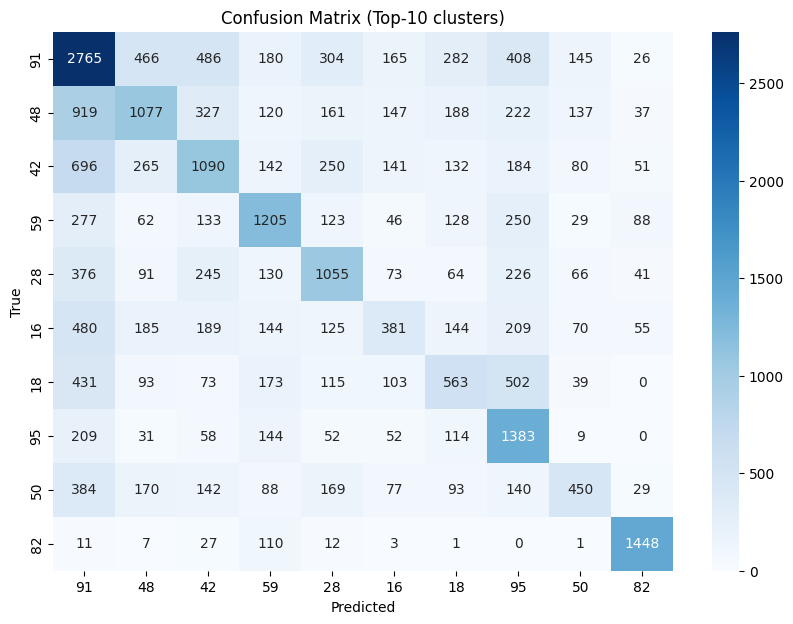

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# True + Pred Labels (aus eurem Validation-Set)
y_true = y_valid
y_pred = y_pred   # aus model.predict(X_valid)

# Häufigste 10 Cluster im Validation-Set
top10_clusters = y_true.value_counts().index[:10]

# Filter auf nur diese Cluster
mask = y_true.isin(top10_clusters)
cm = confusion_matrix(y_true[mask], y_pred[mask], labels=top10_clusters)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=top10_clusters,
            yticklabels=top10_clusters)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Top-10 clusters)")
plt.show()
